<a href="https://colab.research.google.com/github/BlackBoyZeus/MachineLearningNOTEBOOKING/blob/main/cross_attention_renderer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning to Render Novel Views from Wide-Baseline Stereo Pairs

This is a colab to illustrating rendering on unposed camera images using a pretrained cross attention render proposed in our work [Learning to Render Novel Views from Wide-Baseline Stereo Pairs](https://yilundu.github.io/wide_baseline/).


We will first install, clone, and import relevant packages.

**Make sure that you have enabled the GPU under Edit -> Notebook Settings!**

## Initial Setup

In [1]:
!pip install roma==1.2.6
!pip install timm==0.5.4
!pip install einops==0.6.0
!pip install jaxtyping==0.2.14

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.11
    Uninstalling timm-1.0.11:
      Successfully uninstalled timm-1.0.11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: einops
    Found existing installation: einops 0.8.0
    Uninstalling einops-0.8.0:
      Successfully uninstalled einops-0.8.0


In [2]:
import gdown
from imageio import imread
import matplotlib.pyplot as plt
import torch
from skimage.transform import resize as imresize
from imageio import get_writer
import numpy as np
from pathlib import Path

Download Pretrained Model

In [3]:
!git clone https://github.com/yilundu/cross_attention_renderer.git
!gdown https://drive.google.com/uc?id=1hxiyjWYR1UOOcuxTHZw7_B5VNqynmC5f
!mv model_weights.tar.gz cross_attention_renderer/

Cloning into 'cross_attention_renderer'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 133 (delta 39), reused 18 (delta 7), pack-reused 64 (from 1)
Receiving objects: 100% (133/133), 67.82 MiB | 20.33 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Downloading...
From (original): https://drive.google.com/uc?id=1hxiyjWYR1UOOcuxTHZw7_B5VNqynmC5f
From (redirected): https://drive.google.com/uc?id=1hxiyjWYR1UOOcuxTHZw7_B5VNqynmC5f&confirm=t&uuid=a80f090d-caeb-453b-a278-2f4b6123fd02
To: /content/model_weights.tar.gz
100% 1.38G/1.38G [00:29<00:00, 46.3MB/s]


In [4]:
cd cross_attention_renderer


/content/cross_attention_renderer


In [5]:
!tar -zxvf model_weights.tar.gz

000c3ab189999a83.txt
logs/realestate_release_weights/
logs/realestate_release_weights/model_current.pth
000c3ab189999a83/
000c3ab189999a83/data.npz


# Loading Data

Below, we provide two different approaches to render 3D trajecotry videos from our model. The code immediately below renders scenes from RealEstate10K data poses. Alternatively, we can load two different input images and compute their relative camera pose using SuperGLUE correspondences and then construct a trajectory we wish to render given computed camera poses (commented out for now).

In [6]:
from dataset.load_video_superglue import get_camera_pose
from dataset.realestate10k_dataio import get_camera_pose as get_realestate_camera_pose

The code below will load an existing RealEstate10K test trajectory.


In [7]:
i, j = torch.meshgrid(torch.arange(0, 256), torch.arange(0, 256))
uv = torch.stack([i.float(), j.float()], dim=-1).permute(1, 0, 2)

uv = uv[None].permute(0, -1, 1, 2).permute(0, 2, 3, 1)
uv = uv.reshape(-1, 2)

render_info = get_realestate_camera_pose(Path('000c3ab189999a83/'), './', uv, views=2)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/cross_attention_renderer/dataset/realestate10k_dataio.py:180: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  query = {'rgb': torch.Tensor(query_rgbs)[None].float(),


The code below will instead load rendering information given two unposed images, using superpoint to compute relative poses between images. You will
need to adjust the translation distance between images for better rendering performance.

/content/cross_attention_renderer/estimate_pose/superpoint.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(str(path)))
/content/cross_a

Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)


<ipython-input-8-202696299bb1>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im1 = imread(im1_path)
<ipython-input-8-202696299bb1>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im2 = imread(im2_path)


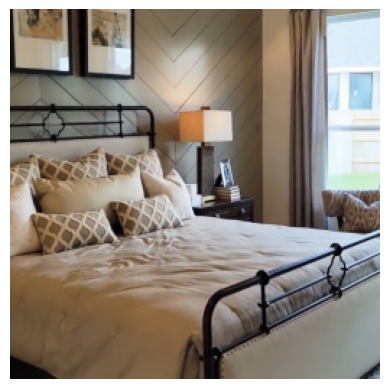

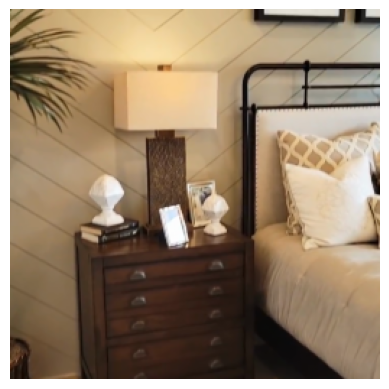

In [8]:
im1_path = "image/demo_first.png"
im2_path = "image/demo_second.png"

i, j = torch.meshgrid(torch.arange(0, 256), torch.arange(0, 256))
uv = torch.stack([i.float(), j.float()], dim=-1).permute(1, 0, 2)

uv = uv[None].permute(0, -1, 1, 2).permute(0, 2, 3, 1)
uv = uv.reshape(-1, 2)

# The sf will need to be adjusted for different input images and represents the relative translation offset between images
render_unposed_info = get_camera_pose(im1_path, im2_path, uv, sf=1.4)

im1 = imread(im1_path)
im2 = imread(im2_path)

h, w, _ = im1.shape
offset = (w - h) // 2

im1 = imresize(im1[:, offset:-offset], (256, 256))
im2 = imresize(im2[:, offset:-offset], (256, 256))

# Show input images into neural network
plt.imshow(im1)
plt.axis('off')
plt.show()
plt.imshow(im2)
plt.axis('off')
plt.show()

In [9]:
render_info.keys()

dict_keys(['query', 'context'])

# Render Trajectory

Next we render the trajectory using a pretrained model. First we load model.

In [10]:
# Load model weights
import models

model = models.CrossAttentionRenderer(model="midas_vit", n_view=2)
state_dict = torch.load('logs/realestate_release_weights/model_current.pth', map_location=torch.device('cpu'))
model.load_state_dict(state_dict['model'])
model = model.cuda()

<ipython-input-10-b8b6ab7ce15f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('logs/realestate_release_weights/model_current.pth', map_location=to

In [11]:
from utils import util
from tqdm import tqdm

# Define Render Data Function
def render_data(model_input, model):
    model_input = util.dict_to_gpu(model_input)

    nrender = model_input['query']['cam2world'].size(1)

    uv = model_input['query']['uv']
    nrays = uv.size(-2)
    chunks = nrays // 2048 + 1
    z = model.get_z(model_input)

    query_cam2world = model_input['query']['cam2world']
    query_intrinsic = model_input['query']['intrinsics']

    writer = get_writer("render.mp4")

    with torch.no_grad():
        for i in tqdm(range(nrender)):
            model_input['query']['cam2world'] = query_cam2world[:, i:i+1]
            model_input['query']['intrinsics'] = query_intrinsic[:, i:i+1]

            uv_i = uv[:, i:i+1]

            uv_chunks = torch.chunk(uv_i, chunks, dim=2)

            model_outputs = []

            for uv_chunk in uv_chunks:
                model_input['query']['uv'] = uv_chunk
                model_output = model(model_input, z=z)
                del model_output['z']
                del model_output['coords']
                # del model_output['ent']
                del model_output['uv']
                del model_output['pixel_val']
                del model_output['at_wts']

                model_outputs.append(model_output)

            model_output_full = {}

            for k in model_outputs[0].keys():
                outputs = [model_output[k] for model_output in model_outputs]
                print(k, [output.size() for output in outputs])
                val = torch.cat(outputs, dim=-2)
                model_output_full[k] = val

            rgb = model_output_full['rgb'].view(256, 256, 3)
            rgb_gt = model_input['query']['rgb'][0, i]

            panel_im = torch.cat([rgb], dim=1).detach().cpu().numpy()
            panel_im = np.clip(panel_im, -1, 1)
            writer.append_data(panel_im)

    writer.close()

In [12]:
# You can substitute render_info with render_unposed_info to render trajectories interpolating between two unposed images
render_data(render_info, model)
# render_data(render_unposed_info, model)

  0%|          | 0/127 [00:00<?, ?it/s]/content/cross_attention_renderer/geometry.py:88: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  return torch.cross(line_1[..., :3].double(), line_2[..., :3].double()).norm(dim=-1) < 1e-12


at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

  2%|▏         | 2/127 [00:19<20:11,  9.69s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

  2%|▏         | 3/127 [00:28<19:45,  9.56s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

  3%|▎         | 4/127 [00:38<19:31,  9.52s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

  4%|▍         | 5/127 [00:47<19:20,  9.51s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

  5%|▍         | 6/127 [00:57<19:10,  9.51s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

  6%|▌         | 7/127 [01:07<19:05,  9.55s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

  6%|▋         | 8/127 [01:16<19:00,  9.58s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

  7%|▋         | 9/127 [01:26<18:53,  9.61s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

  8%|▊         | 10/127 [01:36<18:48,  9.65s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

  9%|▊         | 11/127 [01:45<18:43,  9.68s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

  9%|▉         | 12/127 [01:55<18:37,  9.72s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 10%|█         | 13/127 [02:05<18:29,  9.73s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 11%|█         | 14/127 [02:15<18:22,  9.76s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 12%|█▏        | 15/127 [02:25<18:15,  9.78s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 13%|█▎        | 16/127 [02:34<18:09,  9.82s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 13%|█▎        | 17/127 [02:44<18:02,  9.84s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 14%|█▍        | 18/127 [02:54<18:00,  9.91s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 15%|█▍        | 19/127 [03:05<18:01, 10.02s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 16%|█▌        | 20/127 [03:15<18:07, 10.17s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 17%|█▋        | 21/127 [03:26<18:04, 10.23s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 17%|█▋        | 22/127 [03:36<17:53, 10.22s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 18%|█▊        | 23/127 [03:46<17:39, 10.19s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 19%|█▉        | 24/127 [03:56<17:25, 10.15s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 20%|█▉        | 25/127 [04:06<17:13, 10.13s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 20%|██        | 26/127 [04:16<17:01, 10.11s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 21%|██▏       | 27/127 [04:26<16:54, 10.14s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 22%|██▏       | 28/127 [04:37<16:46, 10.17s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 23%|██▎       | 29/127 [04:47<16:39, 10.20s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 24%|██▎       | 30/127 [04:57<16:28, 10.19s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 24%|██▍       | 31/127 [05:07<16:18, 10.19s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 25%|██▌       | 32/127 [05:17<16:08, 10.19s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 26%|██▌       | 33/127 [05:28<15:57, 10.19s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 27%|██▋       | 34/127 [05:38<15:46, 10.18s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 28%|██▊       | 35/127 [05:48<15:36, 10.18s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 28%|██▊       | 36/127 [05:58<15:27, 10.20s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 29%|██▉       | 37/127 [06:08<15:18, 10.21s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 30%|██▉       | 38/127 [06:19<15:08, 10.21s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 31%|███       | 39/127 [06:29<14:56, 10.19s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 31%|███▏      | 40/127 [06:39<14:46, 10.19s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 32%|███▏      | 41/127 [06:49<14:36, 10.19s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 33%|███▎      | 42/127 [06:59<14:27, 10.20s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 34%|███▍      | 43/127 [07:10<14:16, 10.19s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 35%|███▍      | 44/127 [07:20<14:06, 10.19s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 35%|███▌      | 45/127 [07:30<13:56, 10.20s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 36%|███▌      | 46/127 [07:40<13:47, 10.21s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 37%|███▋      | 47/127 [07:50<13:38, 10.23s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 38%|███▊      | 48/127 [08:01<13:27, 10.22s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 39%|███▊      | 49/127 [08:11<13:18, 10.24s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 39%|███▉      | 50/127 [08:21<13:08, 10.24s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 40%|████      | 51/127 [08:31<12:57, 10.23s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 41%|████      | 52/127 [08:42<12:46, 10.23s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 42%|████▏     | 53/127 [08:52<12:36, 10.22s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 43%|████▎     | 54/127 [09:02<12:27, 10.23s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 43%|████▎     | 55/127 [09:12<12:17, 10.24s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 44%|████▍     | 56/127 [09:23<12:07, 10.24s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 45%|████▍     | 57/127 [09:33<11:56, 10.23s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 46%|████▌     | 58/127 [09:43<11:46, 10.23s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 46%|████▋     | 59/127 [09:53<11:36, 10.24s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 47%|████▋     | 60/127 [10:03<11:25, 10.23s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 48%|████▊     | 61/127 [10:14<11:14, 10.23s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 49%|████▉     | 62/127 [10:24<11:03, 10.21s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 50%|████▉     | 63/127 [10:34<10:53, 10.21s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 50%|█████     | 64/127 [10:44<10:43, 10.22s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 51%|█████     | 65/127 [10:55<10:34, 10.23s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 52%|█████▏    | 66/127 [11:05<10:24, 10.23s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 53%|█████▎    | 67/127 [11:15<10:13, 10.23s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 54%|█████▎    | 68/127 [11:25<10:04, 10.24s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 54%|█████▍    | 69/127 [11:36<09:54, 10.25s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 55%|█████▌    | 70/127 [11:46<09:44, 10.25s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 56%|█████▌    | 71/127 [11:56<09:33, 10.24s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 57%|█████▋    | 72/127 [12:06<09:22, 10.23s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 57%|█████▋    | 73/127 [12:16<09:12, 10.24s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 58%|█████▊    | 74/127 [12:27<09:03, 10.25s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 59%|█████▉    | 75/127 [12:37<08:53, 10.25s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 60%|█████▉    | 76/127 [12:47<08:42, 10.24s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 61%|██████    | 77/127 [12:57<08:32, 10.24s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 61%|██████▏   | 78/127 [13:08<08:21, 10.24s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 62%|██████▏   | 79/127 [13:18<08:11, 10.24s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 63%|██████▎   | 80/127 [13:28<08:01, 10.24s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 64%|██████▍   | 81/127 [13:38<07:50, 10.23s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 65%|██████▍   | 82/127 [13:49<07:40, 10.24s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 65%|██████▌   | 83/127 [13:59<07:30, 10.24s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 66%|██████▌   | 84/127 [14:09<07:20, 10.24s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 67%|██████▋   | 85/127 [14:19<07:09, 10.23s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 68%|██████▊   | 86/127 [14:30<06:59, 10.23s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 69%|██████▊   | 87/127 [14:40<06:48, 10.22s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 69%|██████▉   | 88/127 [14:50<06:38, 10.22s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 70%|███████   | 89/127 [15:00<06:27, 10.20s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 71%|███████   | 90/127 [15:10<06:16, 10.18s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 72%|███████▏  | 91/127 [15:20<06:06, 10.18s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 72%|███████▏  | 92/127 [15:31<05:56, 10.18s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 73%|███████▎  | 93/127 [15:41<05:45, 10.18s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 74%|███████▍  | 94/127 [15:51<05:35, 10.16s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 75%|███████▍  | 95/127 [16:01<05:25, 10.16s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 76%|███████▌  | 96/127 [16:11<05:14, 10.16s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 76%|███████▋  | 97/127 [16:21<05:04, 10.17s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 77%|███████▋  | 98/127 [16:32<04:54, 10.15s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 78%|███████▊  | 99/127 [16:42<04:44, 10.15s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 79%|███████▊  | 100/127 [16:52<04:34, 10.15s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 80%|███████▉  | 101/127 [17:02<04:24, 10.16s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 80%|████████  | 102/127 [17:12<04:13, 10.16s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 81%|████████  | 103/127 [17:22<04:03, 10.14s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 82%|████████▏ | 104/127 [17:32<03:52, 10.13s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 83%|████████▎ | 105/127 [17:42<03:42, 10.12s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 83%|████████▎ | 106/127 [17:53<03:32, 10.11s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 84%|████████▍ | 107/127 [18:03<03:21, 10.10s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 85%|████████▌ | 108/127 [18:13<03:11, 10.09s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 86%|████████▌ | 109/127 [18:23<03:01, 10.10s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 87%|████████▋ | 110/127 [18:33<02:51, 10.11s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 87%|████████▋ | 111/127 [18:43<02:41, 10.11s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 88%|████████▊ | 112/127 [18:53<02:31, 10.10s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 89%|████████▉ | 113/127 [19:03<02:21, 10.12s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 90%|████████▉ | 114/127 [19:13<02:11, 10.12s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 91%|█████████ | 115/127 [19:24<02:01, 10.12s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 91%|█████████▏| 116/127 [19:34<01:51, 10.10s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 92%|█████████▏| 117/127 [19:44<01:41, 10.10s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 93%|█████████▎| 118/127 [19:54<01:30, 10.10s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 94%|█████████▎| 119/127 [20:04<01:20, 10.09s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 94%|█████████▍| 120/127 [20:14<01:10, 10.08s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 95%|█████████▌| 121/127 [20:24<01:00, 10.08s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 96%|█████████▌| 122/127 [20:34<00:50, 10.06s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 97%|█████████▋| 123/127 [20:44<00:40, 10.06s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 98%|█████████▊| 124/127 [20:54<00:30, 10.07s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 98%|█████████▊| 125/127 [21:04<00:20, 10.07s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

 99%|█████████▉| 126/127 [21:14<00:10, 10.10s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

100%|██████████| 127/127 [21:25<00:00, 10.12s/it]

at_wt [torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1986, 64]), torch.Size([2, 1984, 64])]
at_wt_max [torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2, 1986, 1]), torch.Size([2

Next we display video of our rendered results.

In [13]:
# Display Video

from IPython.display import HTML
from base64 import b64encode
mp4 = open('render.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [14]:
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)